In [1]:
# an end to end example showing how the size of the training set impacts training to convergence time

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [3]:
import tensorflow as tf

In [151]:
import tensorflow_addons as tfa

In [263]:
import datetime

In [4]:
import sklearn.preprocessing

In [5]:
import wispy.callbacks

In [6]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [7]:
import pugna.activations
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [8]:
# https://gitlab.com/SpaceTimeKhantinuum/ml/-/blob/master/waveforms/aug2021/data_generation_coprec.py



import numpy as np
import os
import argparse
import datetime
import multiprocessing as mp
import functools
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom
import wispy
import wispy.lalutils
import wispy.logger
import wispy.utils
from wispy import lalutils, rotations
import lal
import lalsimulation as lalsim
import tomlkit
from tomlkit import parse


def cart_to_polar(x, y, z):
    """
    cartesian to spherical polar transformation.
    phi (azimuthal angle) between [0, 2*pi]
    returns: r, theta, phi
    """
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    theta = np.arctan2(hxy, z)
    phi = np.arctan2(y, x)
    phi = phi % (2 * np.pi)
    return r, theta, phi


def polar_to_cart(r, theta, phi):
    """
    spherical polar to cartesian transformation
    returns: x, y, z
    """
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


def gen_data(
        mass_ratio_array,
        chi1_array,
        theta1_array,
        phi1_array,
        chi2_array,
        theta2_array,
        phi2_array,
        total_mass,
        dt,
        t_min,
        t_max,
        f_min,
        distance,
        approximant,
        deltaT,
        f_ref,
        phiRef,
        nproc=1):

    n_samples = mass_ratio_array.shape[0]

    ps = []
    for i in range(n_samples):
        q = mass_ratio_array[i]
        chi1 = chi1_array[i]
        theta1 = theta1_array[i]
        phi1 = phi1_array[i]

        chi2 = chi2_array[i]
        theta2 = theta2_array[i]
        phi2 = phi2_array[i]

        spin1x, spin1y, spin1z = polar_to_cart(chi1, theta1, phi1)
        spin2x, spin2y, spin2z = polar_to_cart(chi2, theta2, phi2)

        m1, m2 = phenom.m1_m2_M_q(total_mass, q)
        params = wispy.lalutils.gen_td_modes_wf_params(
            m1=m1,
            m2=m2,
            approximant=approximant,
            S1x=spin1x,
            S1y=spin1y,
            S1z=spin1z,
            S2x=spin2x,
            S2y=spin2y,
            S2z=spin2z,
            f_min=f_min,
            f_ref=f_ref,
            phiRef=phiRef,
            distance=distance,
            deltaT=deltaT
        )
        ps.append(params)

    times = []
    hlms = []

    func = functools.partial(wispy.lalutils.gen_td_coprec_data,
                             eob_all_ell_2_modes=True, modes=[[2, 2], [2, 1]], t_min=t_min, t_max=t_max
                             )

    # logger.info("running parallel waveform generation")

    with mp.Pool(nproc) as pool:
        returned = pool.map(func, ps)

    # returned is a list of dictionaries
    # we will need to standardise the data to cover the same length of time
    # (although not strictly needed for ANNs...)
    # but resampling like this will be convenient

    times = [ret['times'] for ret in returned]

    # find common times and interpolate data onto common time grid
    common_tmin = np.max(list(map(np.min, times)))
    common_tmax = np.min(list(map(np.max, times)))

    # logger.info(f"common_tmin = {common_tmin}")
    # logger.info(f"common_tmax = {common_tmax}")

    common_times = np.arange(common_tmin, common_tmax, dt)

    ntimes = len(common_times)
    # logger.info(f"ntimes = {ntimes}")

    # hard coding this for now because I'm lazy

    amp_22 = np.zeros(shape=(n_samples, ntimes))
    amp_21 = np.zeros(shape=(n_samples, ntimes))
    phi_22 = np.zeros(shape=(n_samples, ntimes))
    phi_21 = np.zeros(shape=(n_samples, ntimes))
    alpha = np.zeros(shape=(n_samples, ntimes))
    beta = np.zeros(shape=(n_samples, ntimes))
    gamma = np.zeros(shape=(n_samples, ntimes))

    for i in range(n_samples):
        amp_22[i] = IUS(times[i], returned[i]['amp_22'])(common_times)
        amp_21[i] = IUS(times[i], returned[i]['amp_21'])(common_times)
        phi_22[i] = IUS(times[i], returned[i]['phi_22'])(common_times)
        phi_21[i] = IUS(times[i], returned[i]['phi_21'])(common_times)
        alpha[i] = IUS(times[i], returned[i]['alpha'])(common_times)
        beta[i] = IUS(times[i], returned[i]['beta'])(common_times)
        gamma[i] = IUS(times[i], returned[i]['gamma'])(common_times)

    data = dict(
        times=common_times,
        amp_22=amp_22,
        amp_21=amp_21,
        phi_22=phi_22,
        phi_21=phi_21,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
    )

    return data




# data generation

In [301]:
n_samples = 10
mass_ratio_array = np.array([5.]*n_samples)
chi1_array = np.linspace(0, 0.99, n_samples)
theta1_array = np.array([np.pi/2]*n_samples)
phi1_array = np.array([0.]*n_samples)
chi2_array = np.array([0.]*n_samples)
theta2_array = np.array([0.]*n_samples)
phi2_array = np.array([0.]*n_samples)
total_mass = 100.
dt = 5.
t_min = -500.
t_max = 110.
f_min = 17.
distance = 1.
approximant = lalsim.SEOBNRv4P
deltaT = 1./2048.
f_ref = f_min
phiRef = 0.

chi1_val_array = np.random.random(n_samples)

In [302]:
%%time
data = gen_data(
        mass_ratio_array=mass_ratio_array,
        chi1_array=chi1_array,
        theta1_array=theta1_array,
        phi1_array=phi1_array,
        chi2_array=chi2_array,
        theta2_array=theta2_array,
        phi2_array=phi2_array,
        total_mass=total_mass,
        dt=dt,
        t_min=t_min,
        t_max=t_max,
        f_min=f_min,
        distance=distance,
        approximant=approximant,
        deltaT=deltaT,
        f_ref=f_ref,
        phiRef=phiRef,
        nproc=1)

CPU times: user 18.9 ms, sys: 20.2 ms, total: 39.1 ms
Wall time: 9.13 s


In [303]:
%%time
val_data = gen_data(
        mass_ratio_array=mass_ratio_array,
        chi1_array=chi1_val_array,
        theta1_array=theta1_array,
        phi1_array=phi1_array,
        chi2_array=chi2_array,
        theta2_array=theta2_array,
        phi2_array=phi2_array,
        total_mass=total_mass,
        dt=dt,
        t_min=t_min,
        t_max=t_max,
        f_min=f_min,
        distance=distance,
        approximant=approximant,
        deltaT=deltaT,
        f_ref=f_ref,
        phiRef=phiRef,
        nproc=1)

CPU times: user 18.5 ms, sys: 16.7 ms, total: 35.2 ms
Wall time: 9.42 s


In [304]:
data['times'].shape

(122,)

In [305]:
chi1_array

array([0.  , 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99])

In [306]:
data['beta'].shape

(10, 122)

Text(0.5, 1.0, 'training data')

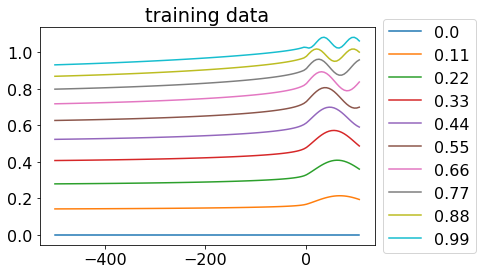

In [307]:
plt.figure()
for i in range(n_samples):
    plt.plot(data['times'], data['beta'][i], label=f"{np.around(chi1_array[i],3)}")
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("training data")

Text(0.5, 1.0, 'validation data')

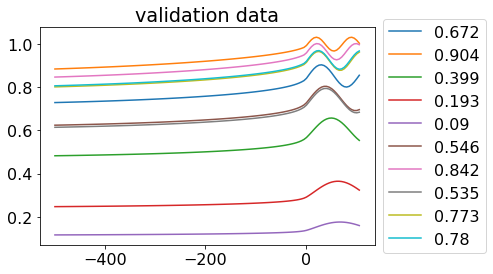

In [308]:
plt.figure()
for i in range(n_samples):
    plt.plot(data['times'], val_data['beta'][i], label=f"{np.around(chi1_val_array[i],3)}")
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("validation data")

# fits

## pre-procesing

In [309]:
times_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=[-1,0])

In [310]:
times = data['times'].reshape(-1,1)

In [311]:
times_scaled = times_scaler.fit_transform(times)

In [312]:
times_scaled.shape

(122, 1)

In [313]:
X_train = chi1_array.copy().reshape(-1, 1)
y_train = data["beta"].copy()

X_val = chi1_val_array.copy().reshape(-1, 1)
y_val = val_data["beta"].copy()

In [314]:
X_train.shape

(10, 1)

In [315]:
y_train.shape

(10, 122)

In [316]:
X_val.shape

(10, 1)

In [317]:
y_val.shape

(10, 122)

Text(0.5, 1.0, 'training data')

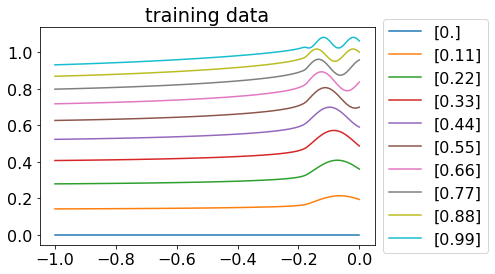

In [318]:
plt.figure()
for i in range(X_train.shape[0]):
    plt.plot(times_scaled, y_train[i], label=f"{np.around(X_train[i],3)}")
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("training data")

In [219]:
def build_model(input_shape, output_shape, units, activation, n_hidden_layers):
    
    input_layer = tf.keras.Input(shape=(input_shape,))
    x = input_layer
    for i in range(n_hidden_layers):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        
#     dense_skip = tf.keras.layers.Dense(units, activation=activation)(input_layer)
#     x = tf.keras.layers.add([dense_skip, x])
    output_layer = tf.keras.layers.Dense(output_shape)(x)
    
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [262]:
class Run(object):
    def __init__(self, name, params):
        self.name = name
        self.params = params
        
    def plot_history(self, history):
        plt.figure()
        plt.plot(history.history['loss'], label='loss 1', c='C0')
        plt.plot(history.history['val_loss'], label='val 1', c='C0', ls='--')

        plt.axhline(1e-05, c='k', ls='--')

        plt.yscale('log')
        plt.xscale('log')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    def plot_lr(self, history):
        plt.figure()
        plt.plot(history.history['lr'], label='lr', c='C0')


        plt.yscale('log')
        plt.xscale('log')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [221]:
run0 = Run(
    name='run0',
    params=dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units=256,
    activation='s2relu',
    n_hidden_layers=5
))

In [222]:
run0.name

'run0'

In [246]:
run0.params

{'input_shape': 1,
 'output_shape': 305,
 'units': 256,
 'activation': 's2relu',
 'n_hidden_layers': 5}

In [247]:
run0.model = build_model(**run0.params)

In [248]:
run0.model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_60 (Dense)             (None, 256)               512       
_________________________________________________________________
dense_61 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_62 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_63 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_64 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_65 (Dense)             (None, 305)               783

In [249]:
run0.model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [250]:
%%time
callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=1000, min_lr=1e-6),
    wispy.callbacks.ThresholdCallback(1e-9),
    tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
]
run0.history = run0.model.fit(X_train, y_train, epochs=10000, batch_size=64, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 6min 34s, sys: 29.7 s, total: 7min 4s
Wall time: 6min 14s


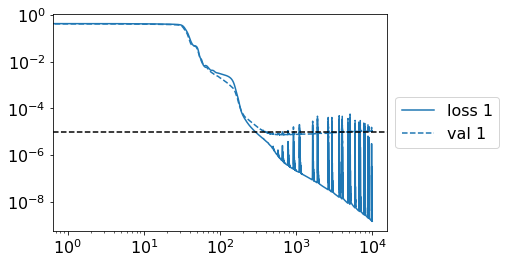

In [251]:
run0.plot_history(run0.history)

In [253]:
run0.model.predict(X_train).shape

(10, 305)

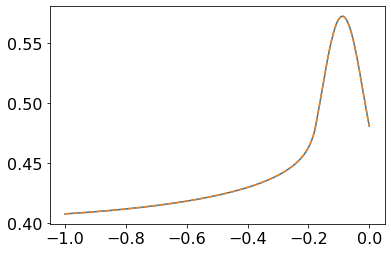

In [254]:
index=3
plt.figure()
plt.plot(times_scaled, y_train[index])
plt.plot(times_scaled, run0.model.predict(X_train)[index], ls='--')

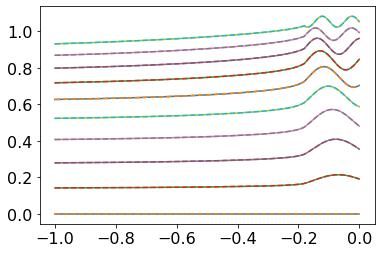

In [255]:
plt.figure()
for i in range(y_train.shape[0]):
    plt.plot(times_scaled, y_train[i])
    plt.plot(times_scaled, run0.model.predict(X_train)[i], ls='--')

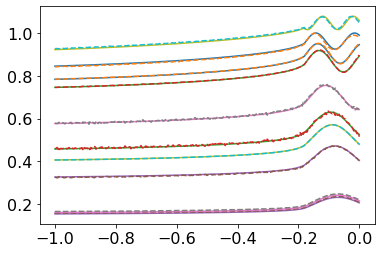

In [256]:
plt.figure()
for i in range(y_train.shape[0]):
    plt.plot(times_scaled, y_val[i])
    plt.plot(times_scaled, run0.model.predict(X_val)[i], ls='--')

# increasing training set size

In [319]:
%%time
ts_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
runs = []

# epochs = 10000
epochs = 2000

for i, ts_size in enumerate(ts_sizes):
    print(f"counter: {i}")
    print(f"working ts_size: {ts_size}")
    this_run = Run(
        name=f'run_{i}',
        params=dict(
        input_shape=X_train.shape[1],
        output_shape=y_train.shape[1],
        units=256,
        activation='s2relu',
        n_hidden_layers=5
    ))
    this_run.model = build_model(**this_run.params)
    this_run.model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
    
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=1000, min_lr=1e-6),
        wispy.callbacks.ThresholdCallback(1e-9),
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
    ]
    start_time = datetime.datetime.now()
    this_X_train = X_train[:ts_size]
    this_y_train = y_train[:ts_size]
    this_run.history = this_run.model.fit(this_X_train, this_y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=False, callbacks=callbacks)
    end_time = datetime.datetime.now()
    dur = end_time - start_time
    print(f"dur: {dur}")
    runs.append(this_run)

counter: 0
working ts_size: 1


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

dur: 0:00:00.810518
counter: 1
working ts_size: 2


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

dur: 0:00:30.784577
counter: 2
working ts_size: 3


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

dur: 0:00:16.163393
counter: 3
working ts_size: 4


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

dur: 0:00:46.278949
counter: 4
working ts_size: 5


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

dur: 0:00:56.746799
counter: 5
working ts_size: 6


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

dur: 0:00:47.041982
counter: 6
working ts_size: 7


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

dur: 0:01:18.531743
counter: 7
working ts_size: 8


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

dur: 0:01:19.934481
counter: 8
working ts_size: 9


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

dur: 0:01:18.899816
counter: 9
working ts_size: 10


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

dur: 0:01:18.506481
CPU times: user 8min 48s, sys: 39.2 s, total: 9min 27s
Wall time: 8min 34s


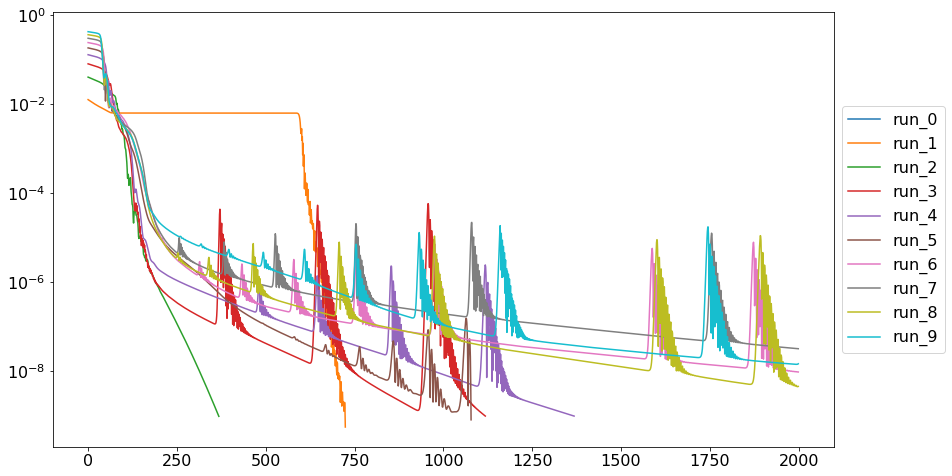

In [320]:
plt.figure(figsize=(14,8))
for i, run in enumerate(runs):
    plt.plot(run.history.history['loss'], label=run.name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

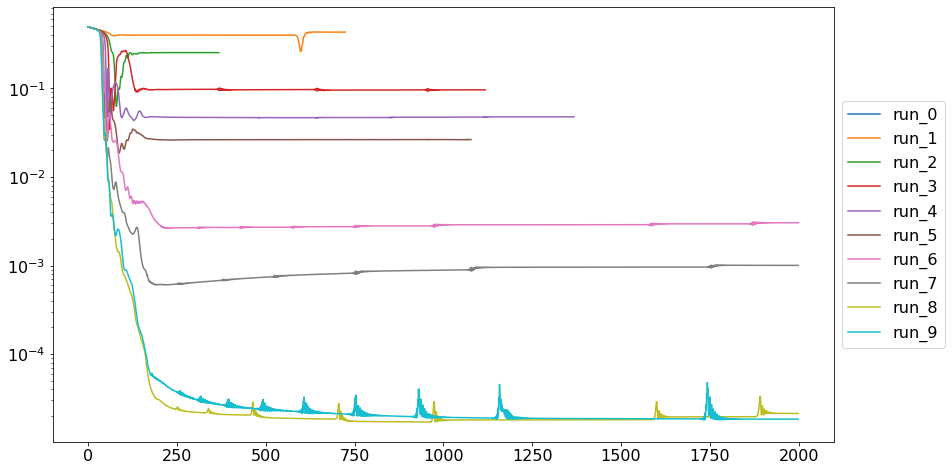

In [321]:
plt.figure(figsize=(14,8))
for i, run in enumerate(runs):
    plt.plot(run.history.history['val_loss'], label=run.name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

In [ ]:
# as the training set size inceases the number of epochs
# needed to reach the error threshold increases a lot.
# is there something we can do to the network arcitecture to help with this?

In [326]:
X_train.shape

(10, 1)

In [ ]:
def build_subnetwork_model(input_shape, output_shape, units, activation, n_hidden_layers):
    
    input_layer = tf.keras.Input(shape=(input_shape,))
    x = input_layer
    for i in range(n_hidden_layers):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        
#     dense_skip = tf.keras.layers.Dense(units, activation=activation)(input_layer)
#     x = tf.keras.layers.add([dense_skip, x])
    output_layer = tf.keras.layers.Dense(output_shape)(x)
    
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)